# Document Image Classification - Exploratory Data Analysis (EDA)

This notebook performs a thorough exploratory data analysis on the document image dataset.

**Analysis Goals:**
1. Understand the basic structure and class distribution of the dataset.
2. Analyze the visual characteristics of the images (dimensions, aspect ratio, channels).
3. Visualize image samples for each class to gain qualitative insights.
4. Explore suitable data augmentation techniques for document images.
5. Analyze inter-class similarity to identify potentially confusing classes for the model.

## 1. Setup and Library Imports

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2
from PIL import Image
from pathlib import Path
from collections import Counter
from tqdm.notebook import tqdm

# Visualization styles
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

# Set a random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

## 2. Dataset Path and Basic Info

In [2]:
# !!! IMPORTANT: Please modify this path to your dataset location.
# This notebook assumes it is located in the 'notebooks' folder of the project root.
DATASET_PATH = "../data/dataset" # Example path

dataset_path = Path(DATASET_PATH)
if not dataset_path.exists():
    print(f"'ERROR: Dataset path not found: {dataset_path}\nCreate the directory and place your dataset there, or update the `DATASET_PATH` variable.")
else:
    print(f"Dataset path: {dataset_path}")

Dataset path: ../data/dataset


In [3]:
# Get class list and count
if dataset_path.exists():
    class_dirs = sorted([d.name for d in dataset_path.iterdir() if d.is_dir()])
    print(f"Total number of classes: {len(class_dirs)}")
    print(f"Class list: {class_dirs}")
else:
    class_dirs = []

Total number of classes: 10
Class list: ['ADVE', 'Email', 'Form', 'Letter', 'Memo', 'News', 'Note', 'Report', 'Resume', 'Scientific']


/tmp/ipykernel_327117/336268842.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='viridis')


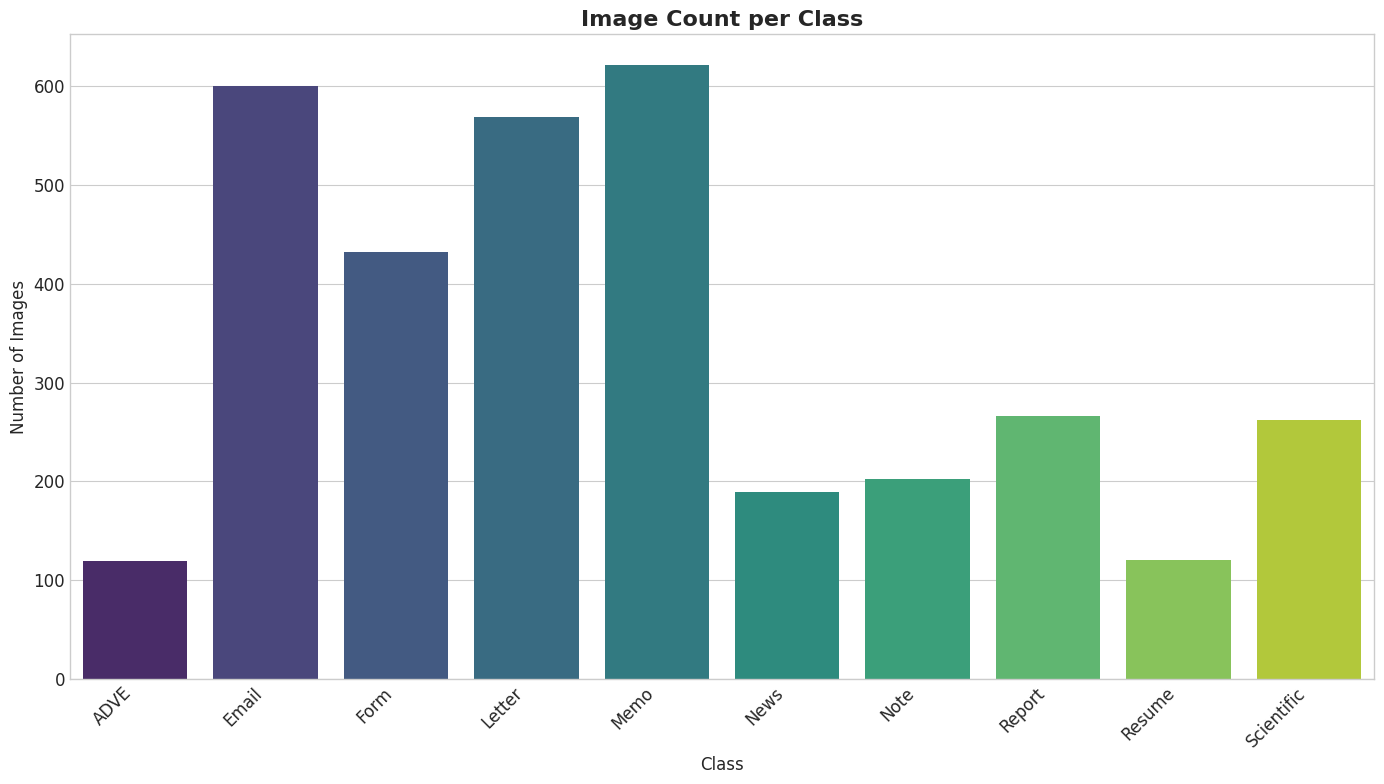


Total images: 3381
Imbalance ratio (max/min): 5.17


In [4]:
# Analyze and visualize class distribution
if class_dirs:
    class_counts = {cls: len([f for f in (dataset_path/cls).iterdir() if f.is_file()]) for cls in class_dirs}

    # Visualization
    plt.figure(figsize=(14, 8))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='viridis')
    plt.title('Image Count per Class', fontsize=16, fontweight='bold')
    plt.xlabel('Class', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Imbalance analysis
    total_images = sum(class_counts.values())
    min_count = min(class_counts.values())
    max_count = max(class_counts.values())
    imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')
    
    print(f"\nTotal images: {total_images}")
    print(f"Imbalance ratio (max/min): {imbalance_ratio:.2f}")

## 3. Image Feature Analysis

We analyze the physical properties of the images like dimensions, aspect ratios, and color channels. We will sample a subset of images if the dataset is large to speed up the analysis.

In [5]:
# Collect image stats
img_stats = []
if class_dirs:
    all_img_paths = [p for cls in class_dirs for p in (dataset_path/cls).glob('*.jpg') if p.is_file()]
    
    # Sample images for faster analysis
    sample_size = min(2000, len(all_img_paths))
    sampled_paths = random.sample(all_img_paths, sample_size)

    for path in tqdm(sampled_paths, desc="Analyzing image stats"):
        try:
            with Image.open(path) as img:
                width, height = img.size
                img_stats.append({
                    'path': str(path),
                    'class': path.parent.name,
                    'width': width,
                    'height': height,
                    'aspect_ratio': width / height if height > 0 else 0,
                    'mode': img.mode
                })
        except Exception as e:
            print(f"Error processing {path}: {e}")

    df_stats = pd.DataFrame(img_stats)
    display(df_stats.head())
    display(df_stats.describe())

Analyzing image stats:   0%|          | 0/2000 [00:00<?, ?it/s]

,path,class,width,height,aspect_ratio,mode
0,../data/dataset/Note/2021387400_7401.jpg,Note,1728,2292,0.753927,L
1,../data/dataset/Email/2074686186a_6187.jpg,Email,1728,2292,0.753927,L
2,../data/dataset/ADVE/502472358.jpg,ADVE,2544,3300,0.770909,L
3,../data/dataset/Resume/40010133-0134.jpg,Resume,1728,2292,0.753927,L
4,../data/dataset/Form/522409061+-9064.jpg,Form,1728,2292,0.753927,L


,width,height,aspect_ratio
count,2000.000000,2000.0000,2000.000000
mean,2085.751500,2716.5260,0.766275
std,424.218797,519.0952,0.025843
min,1200.000000,1575.0000,0.610687
25%,1728.000000,2292.0000,0.753927
50%,1728.000000,2292.0000,0.753927
75%,2544.000000,3285.0000,0.776699
max,3392.000000,4400.0000,1.472840


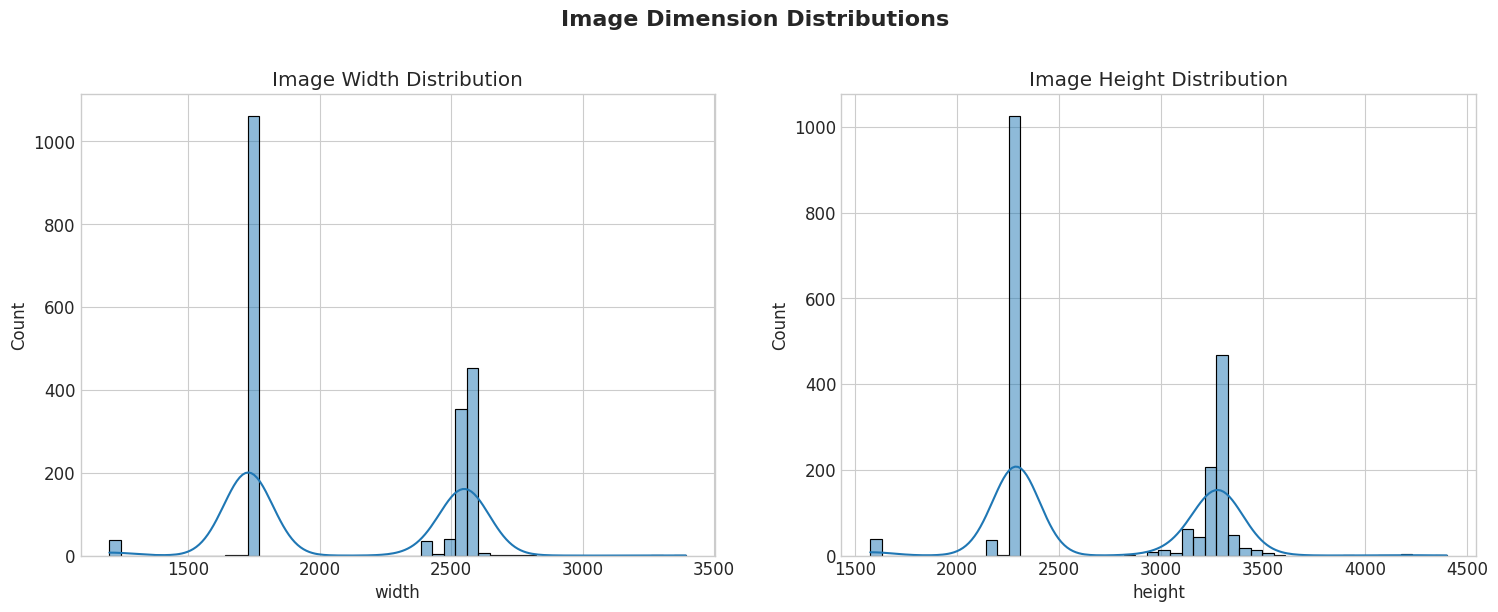

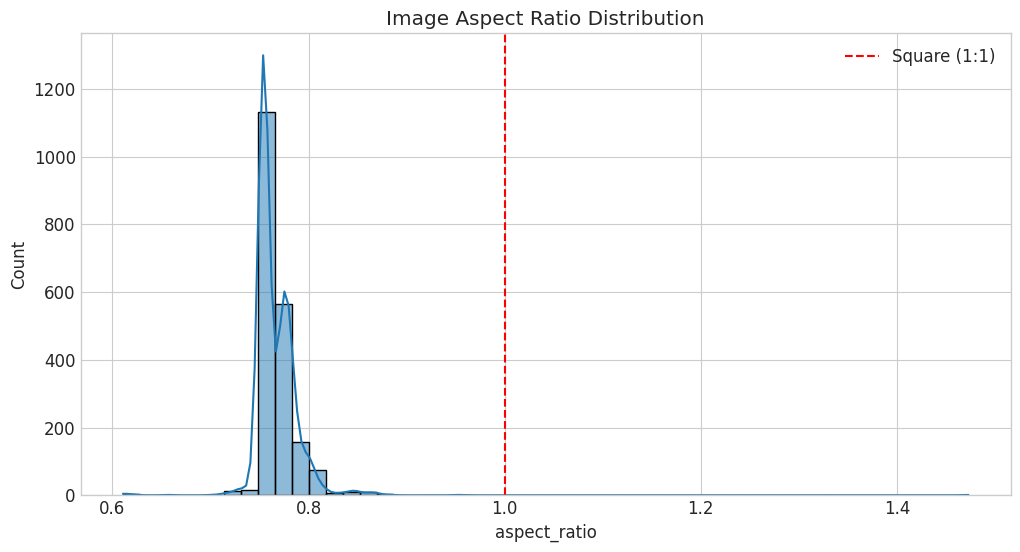

In [6]:
# Visualize image dimensions and aspect ratios
if not df_stats.empty:
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    sns.histplot(data=df_stats, x='width', bins=50, ax=axes[0], kde=True).set_title('Image Width Distribution')
    sns.histplot(data=df_stats, x='height', bins=50, ax=axes[1], kde=True).set_title('Image Height Distribution')
    plt.suptitle('Image Dimension Distributions', fontsize=16, y=1.02, fontweight='bold')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df_stats, x='aspect_ratio', bins=50, kde=True).set_title('Image Aspect Ratio Distribution')
    plt.axvline(x=1.0, color='r', linestyle='--', label='Square (1:1)')
    plt.legend()
    plt.show()

## 4. Visualizing Class Samples
Let's look at some examples from each class to understand their visual content.

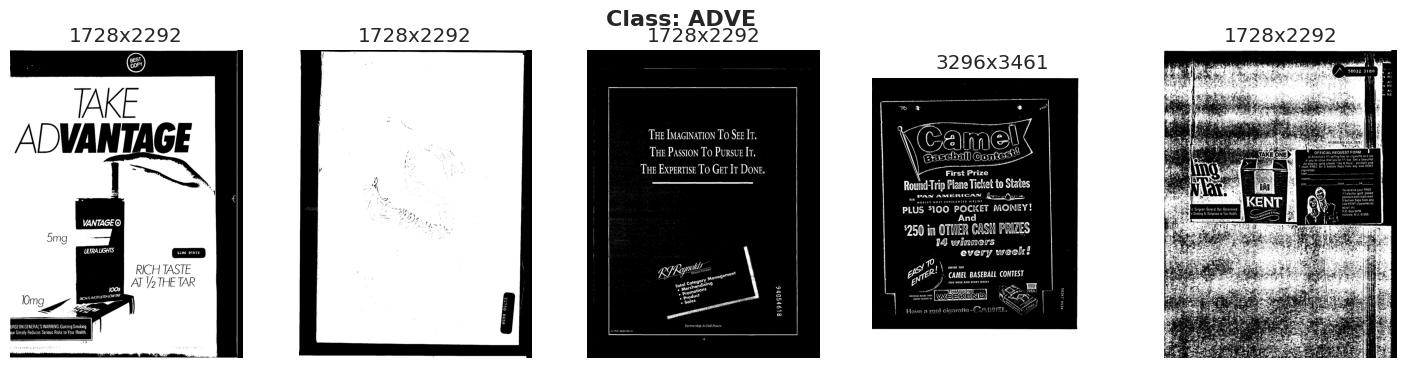

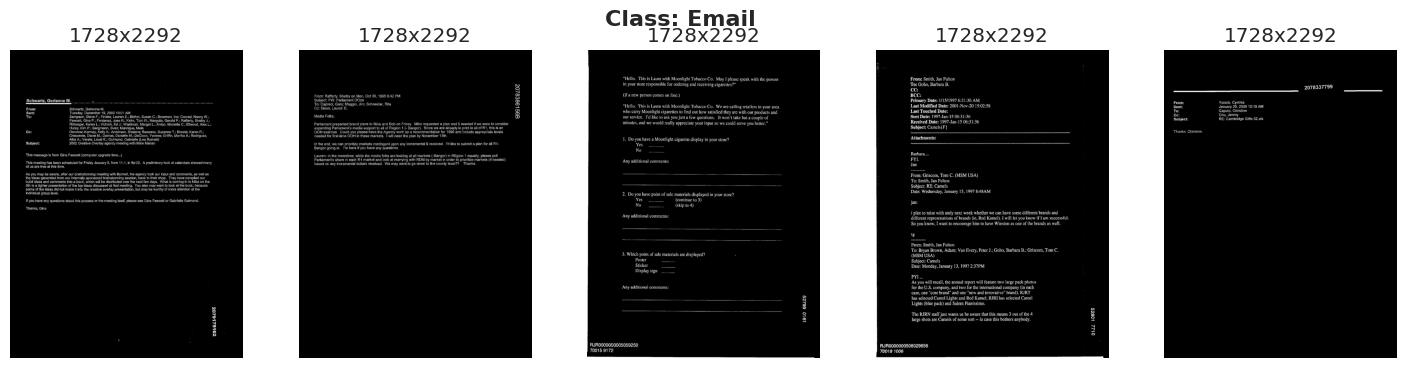

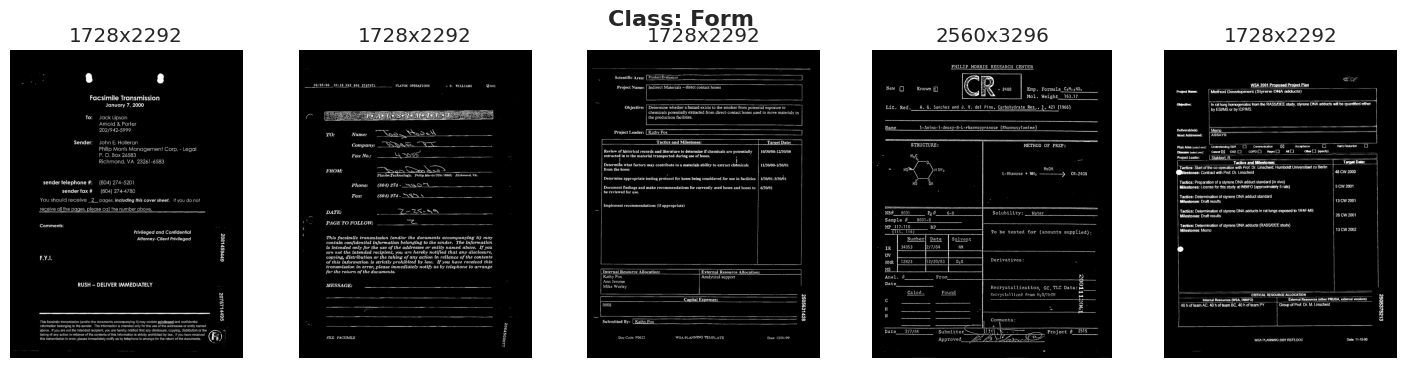

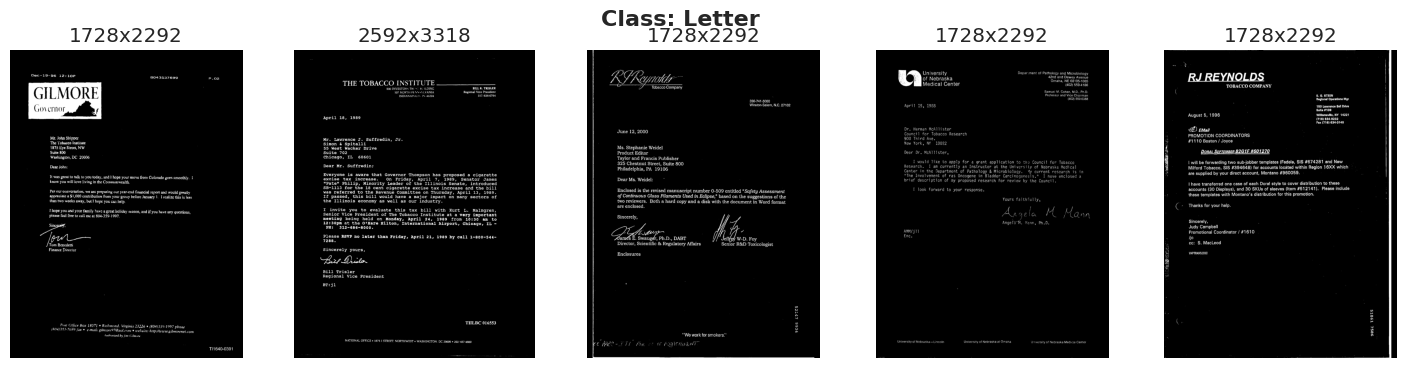

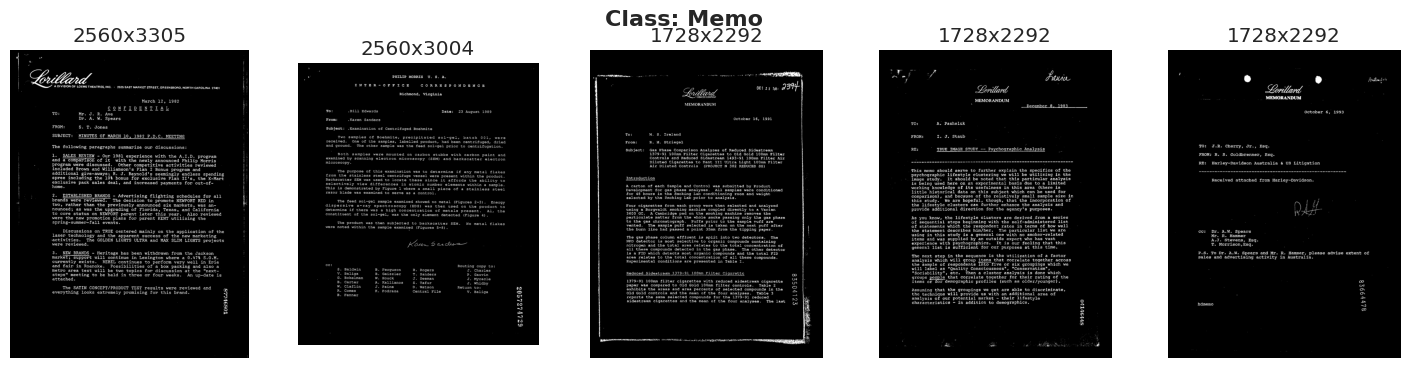

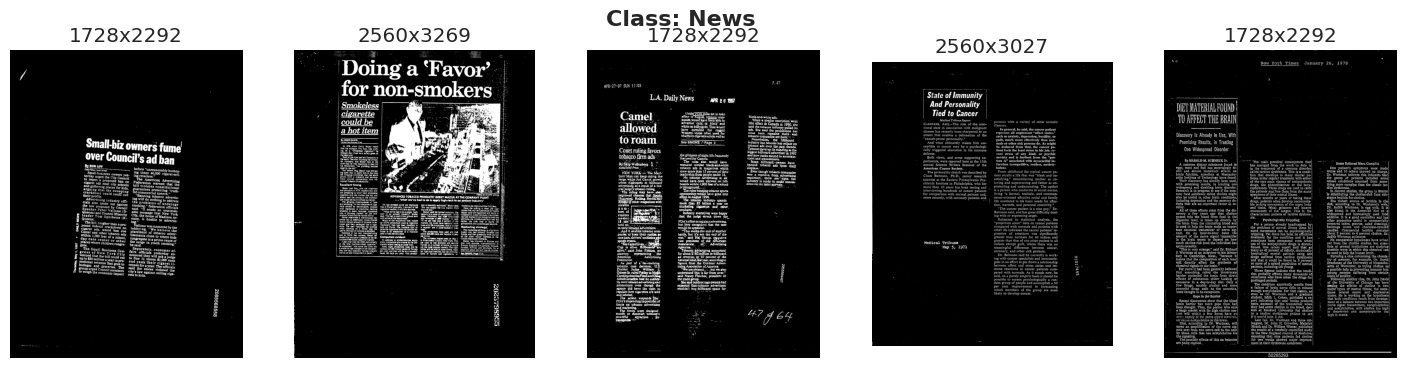

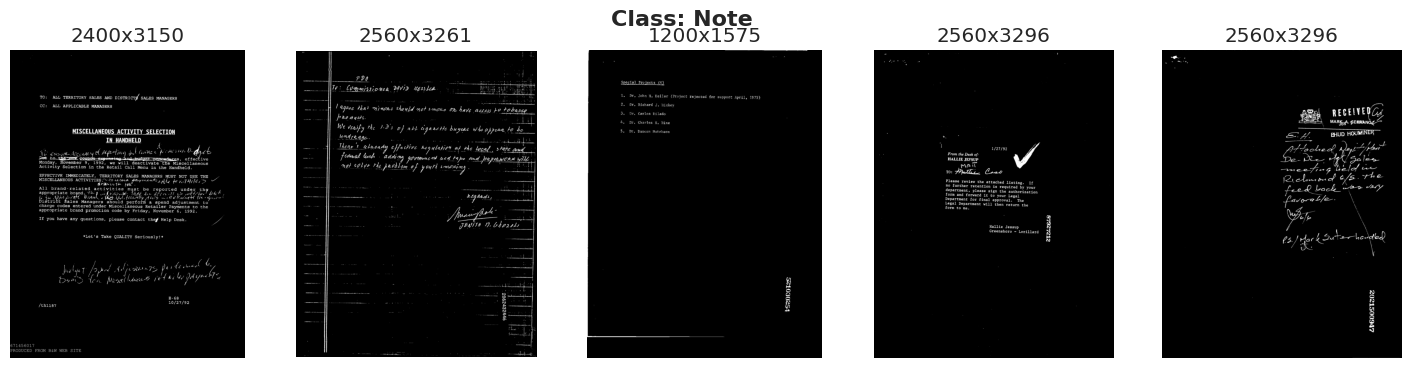

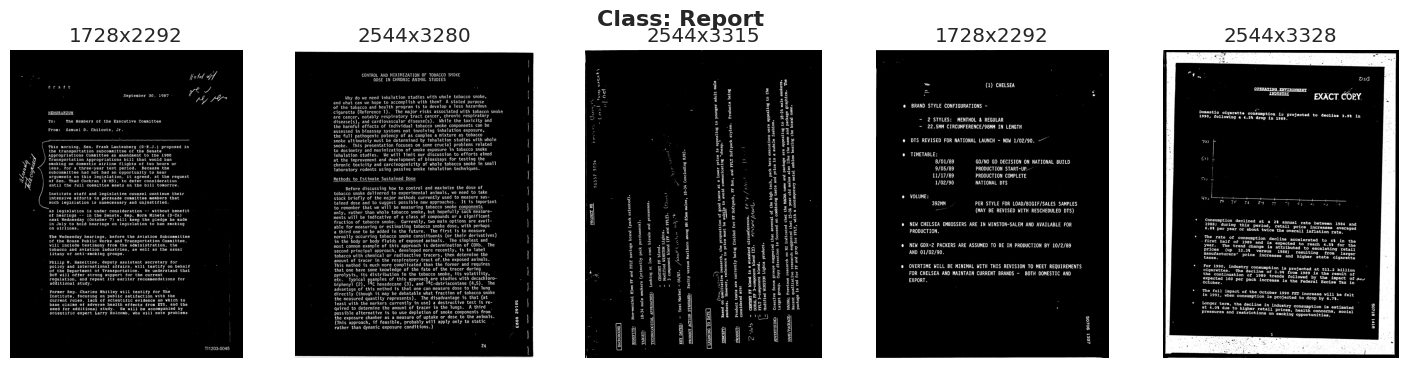

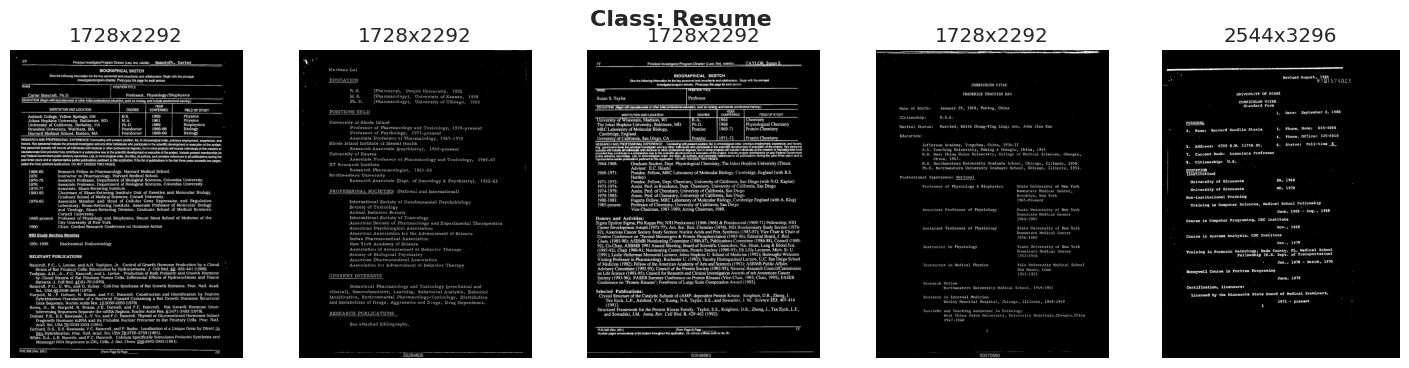

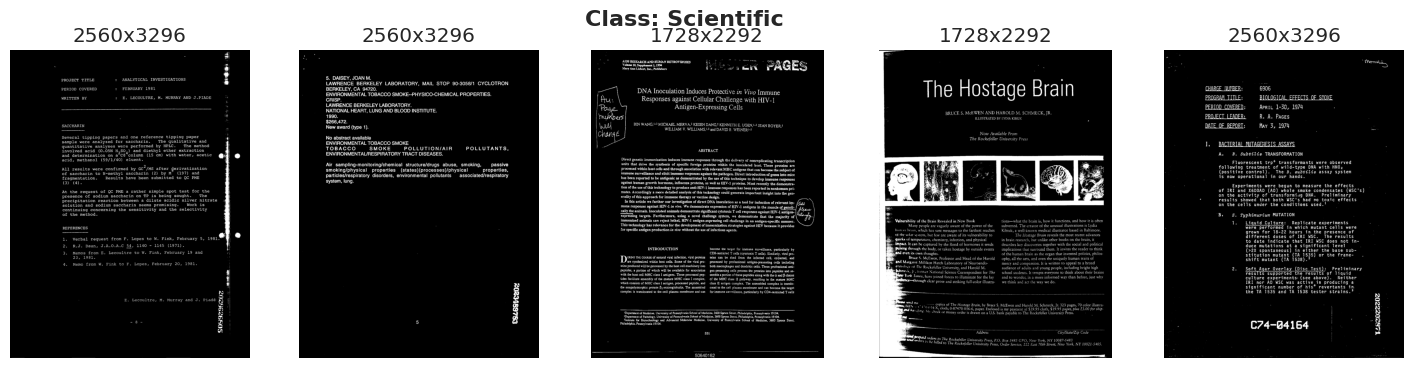

In [8]:
# Function to visualize samples
def visualize_class_samples(path, class_name, num_samples=5):
    class_path = path / class_name
    # Only include files with common image extensions
    img_files = [p for p in class_path.iterdir() if p.is_file() and p.suffix.lower() in {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif'}]
    if not img_files:
        return

    sampled_files = random.sample(img_files, min(num_samples, len(img_files)))

    fig, axes = plt.subplots(1, len(sampled_files), figsize=(18, 4))
    if len(sampled_files) == 1:
        axes = [axes]

    for ax, img_path in zip(axes, sampled_files):
        try:
            img = Image.open(img_path)
            ax.imshow(img)
            ax.set_title(f"{img.width}x{img.height}")
            ax.axis('off')
        except Exception as e:
            ax.set_title("Error")
            ax.axis('off')

    fig.suptitle(f'Class: {class_name}', fontsize=16, fontweight='bold')
    plt.show()

# Visualize for all classes
if class_dirs:
    for cls in class_dirs:
        visualize_class_samples(dataset_path, cls)


## 5. EDA 요약 및 다음 단계

**1. 데이터 분포:**
- (발견 사항 설명) 데이터셋이 불균형합니다. 클래스 X와 Y가 Z보다 훨씬 많은 샘플을 가지고 있습니다. 이는 훈련 중 가중 샘플링이나 손실 함수와 같은 기법 사용을 시사합니다.

**2. 이미지 특성:**
- (발견 사항 설명) 이미지 크기가 매우 다양합니다. 크기 조정 전처리 단계가 중요합니다. 대부분의 이미지가 RGB 형식이지만, 오류를 방지하기 위해 모든 이미지를 3채널로 변환해야 합니다.

**3. 잠재적 과제:**
- (발견 사항 설명) 시각적 검사와 유사성 분석(수행된 경우)을 바탕으로, '송장'과 '영수증' 클래스가 시각적으로 유사하여 모델이 구분하기 어려울 수 있습니다.

**다음 단계:**
- **전처리:** 이미지 크기를 표준화하고 픽셀 값을 정규화합니다.
- **증강:** 문서에 적합한 증강 기법을 적용합니다(예: 회전, 노이즈, 밝기/대비 변경, 가능하면 `augraphy` 사용).
- **모델링:** ResNet50과 같은 견고한 베이스라인 모델로 시작합니다. DataLoader에서 `WeightedRandomSampler`를 사용하여 클래스 불균형 문제를 해결합니다.


## 5. EDA Summary and Next Steps

**1. Data Distribution:**
- (Describe findings) The dataset is imbalanced. Classes X and Y have significantly more samples than Z. This suggests using techniques like weighted sampling or loss functions during training.

**2. Image Characteristics:**
- (Describe findings) Image dimensions vary widely. A resizing preprocessing step is crucial. Most images are in RGB format, but we should ensure all are converted to 3 channels to avoid errors.

**3. Potential Challenges:**
- (Describe findings) Based on visual inspection and similarity analysis (if performed), classes 'invoice' and 'receipt' appear visually similar and might be hard for the model to distinguish.

**Next Steps:**
- **Preprocessing:** Standardize image sizes and normalize pixel values.
- **Augmentation:** Apply augmentations suitable for documents (e.g., rotation, noise, brightness/contrast changes, possibly from `augraphy`).
- **Modeling:** Start with a robust baseline model like ResNet50. Address class imbalance using a `WeightedRandomSampler` in the DataLoader.
